In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from scipy import stats

import forecast

import warnings
warnings.filterwarnings("ignore")

# 1. Data Acquisition

In [2]:
tesla_raw_data = pd.read_csv('tesla_raw_data.csv', index_col = 'Date', parse_dates=True)

In [3]:
tesla_raw_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-09-01,502.140015,502.489990,329.880005,429.010010,429.010010,1736563100
2020-10-01,440.760010,465.899994,379.109985,388.040009,388.040009,833832100
2020-11-01,394.000000,607.799988,392.299988,567.599976,567.599976,782494200
2020-12-01,597.590027,695.000000,541.210022,695.000000,695.000000,879907900
2020-12-18,668.900024,695.000000,628.539978,695.000000,695.000000,222126194


In [4]:
tesla_raw_data.index

DatetimeIndex(['2010-06-01', '2010-07-01', '2010-08-01', '2010-09-01',
               '2010-10-01', '2010-11-01', '2010-12-01', '2011-01-01',
               '2011-02-01', '2011-03-01',
               ...
               '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01', '2020-12-18'],
              dtype='datetime64[ns]', name='Date', length=128, freq=None)

# 2. Data Pre-processing

### 2.1 Keep date and closing price

In [5]:
tesla_price = tesla_raw_data[['Close']].head(len(tesla_raw_data)-1)

In [6]:
tesla_price

,Close
Date,
2010-06-01,4.766000
2010-07-01,3.988000
2010-08-01,3.896000
2010-09-01,4.082000
2010-10-01,4.368000
...,...
2020-08-01,498.320007
2020-09-01,429.010010
2020-10-01,388.040009


### 2.3 Check for null values

In [7]:
tesla_cleaned_data = tesla_price
tesla_cleaned_data.isnull().sum()

Close    0
dtype: int64

There is no null values in dataset

# 3. Exploratory Data Analysis

### 3.1 Summary Statistics

In [8]:
def summary_stats(df):
    summary_statistics = []
    statistics_columns = ["Mean", "Median", "Standard Deviation", 
                          "Sample Variance","Kurtosis", 
                          "Skewness", "Range", "Minimum", 
                          "Maximum", "Sum", "Count"] # measures of statistics
    selected_cols = []
    for column in df:
        if df[column].dtype == np.float64 or df[column].dtype == np.int64: #checks if column is numerical type
            current = [] #list holding current statistics

            #measures key statistics of column
            current.append(df[column].mean())
            current.append(df[column].median())
            current.append(df[column].std())
            current.append(df[column].var())
            current.append(df[column].kurt())
            current.append(df[column].skew())
            current.append(df[column].max() - df[column].min())
            current.append(df[column].min())
            current.append(df[column].max())
            current.append(df[column].sum())
            current.append(df[column].count())

            summary_statistics.append(current)#append statistics of column to list
            selected_cols.append(column)

    statistics = pd.DataFrame()
    for i in range(len(summary_statistics)):
        statistics[selected_cols[i]] = summary_statistics[i]
    statistics.insert(0, "Measure of statistics", statistics_columns)
    statistics.set_index("Measure of statistics", inplace = True)
    return statistics

In [9]:
summary_stats(tesla_cleaned_data)

,Close
Measure of statistics,
Mean,62.926110
Median,44.692001
Standard Deviation,102.638185
Sample Variance,10534.596922
Kurtosis,18.919223
Skewness,4.155832
Range,691.104000
Minimum,3.896000
Maximum,695.000000


### 3.2 Time Series plot

In [10]:
def stationarity_plot(df, order="", transformation=""):
    rolmean = df.rolling(window=12).mean()
    rolstd = df.rolling(window=12).std()
    fig, ax= plt.subplots(figsize=(15,5))
    plt.plot(df['Close'], label='Original')
    plt.plot(rolmean, label='Rolling 12 month average')
    plt.plot(rolstd, label='Rolling 12 month STDEV')
    plt.legend(loc='best')
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.set_title('Tesla stock price {} {}'.format(order, transformation))
    plt.show()

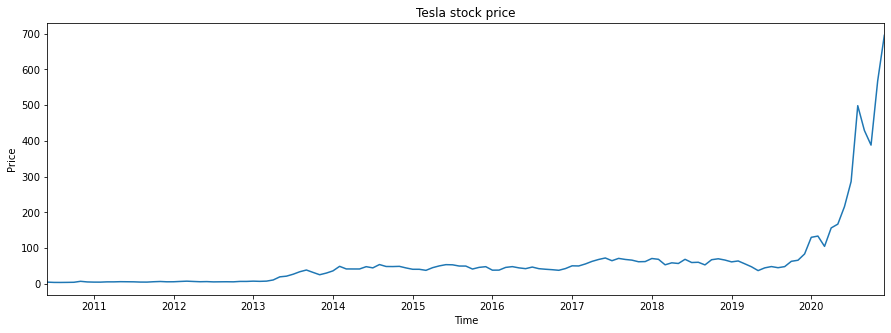

In [11]:
fig, ax= plt.subplots(figsize=(15,5))
tesla_cleaned_data['Close'].plot()
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_title('Tesla stock price')
ax.set_xticks([], minor=True)
plt.show()

Tesla's stock price exhibit positive trend with huge growth in 2020.

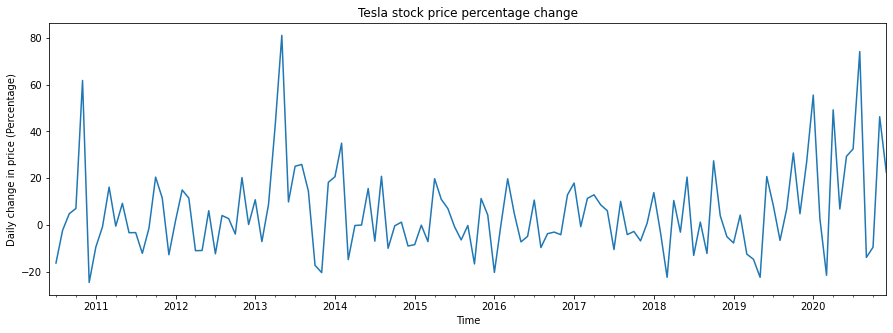

In [12]:
fig, ax= plt.subplots(figsize=(15,5))
(tesla_cleaned_data['Close'].pct_change()*100).plot()
ax.set_xlabel('Time')
ax.set_ylabel('Daily change in price (Percentage)')
ax.set_title('Tesla stock price percentage change')
plt.show()

Tesla's stock price have been more volatile in 2020.

In [13]:
tesla_cleaned_data['Close']

Date
2010-06-01      4.766000
2010-07-01      3.988000
2010-08-01      3.896000
2010-09-01      4.082000
2010-10-01      4.368000
                 ...    
2020-08-01    498.320007
2020-09-01    429.010010
2020-10-01    388.040009
2020-11-01    567.599976
2020-12-01    695.000000
Name: Close, Length: 127, dtype: float64

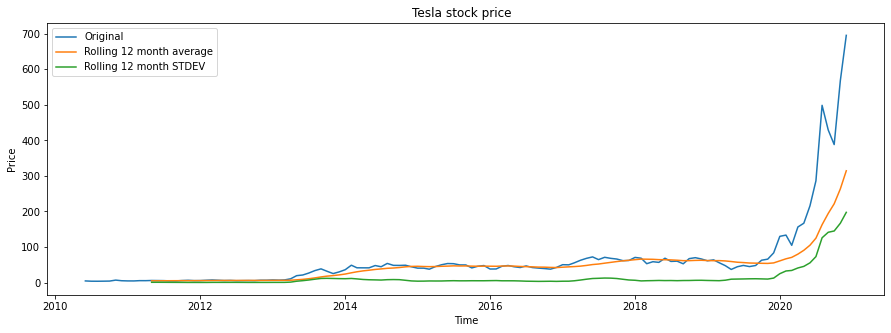

In [14]:
stationarity_plot(tesla_cleaned_data)

Rolling average is not constant, however, variance is relatively constant, except for 2020 period. Thus, feature engineering is required to make data stationary.

### 3.3 Time Series Decomposition

#### 3.3.1 Additive

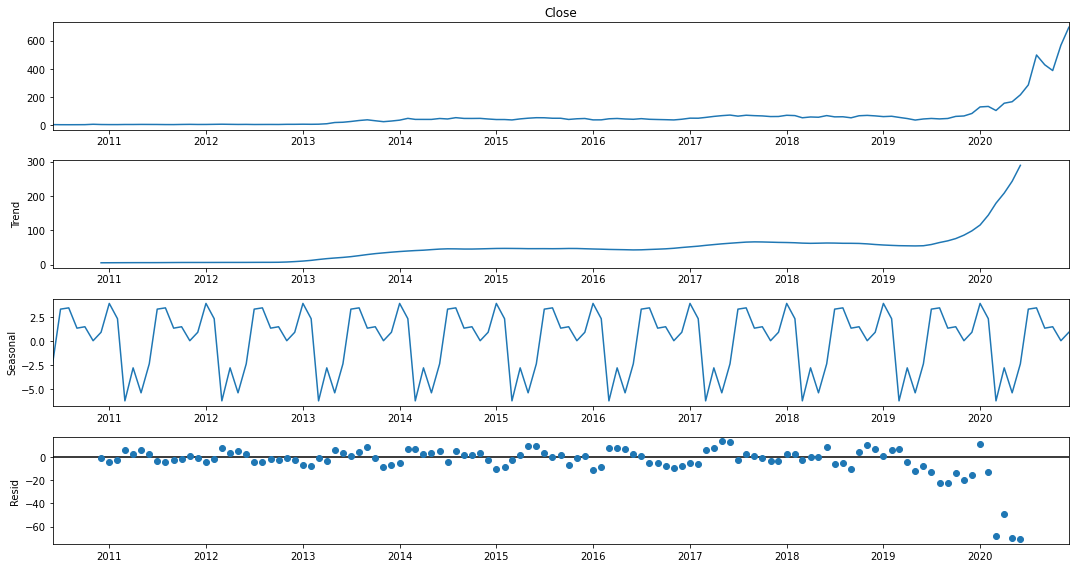

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(tesla_cleaned_data['Close'], model='additive', period=12)
plt.rcParams['figure.figsize'] = [15, 8]
result.plot()
plt.show()

#### 3.3.2 Multiplicative

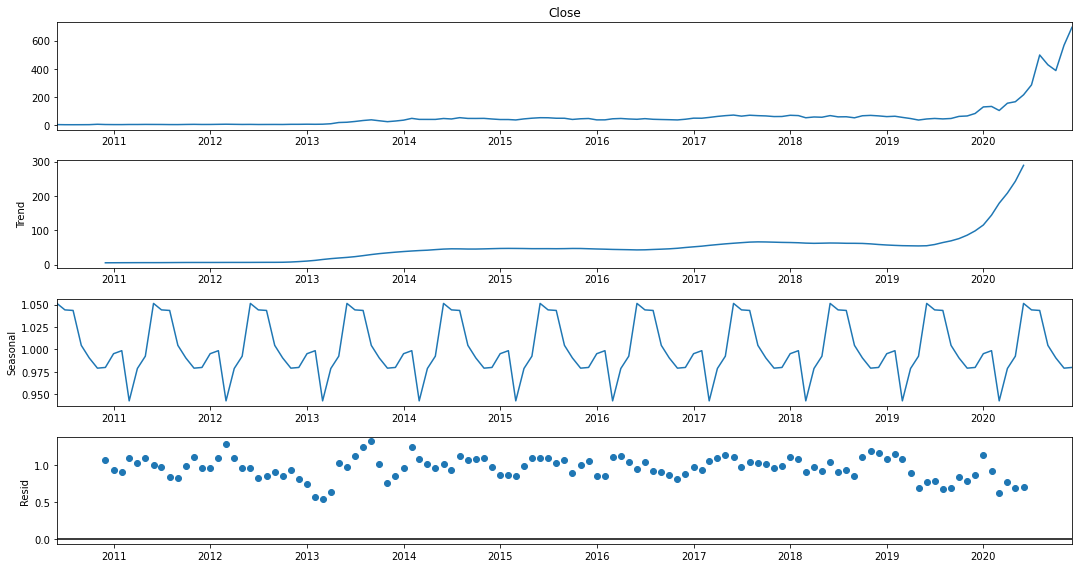

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(tesla_cleaned_data['Close'], model='multiplicative', period=12)
plt.rcParams['figure.figsize'] = [15, 8]
result.plot()
plt.show()

Multiplicative is able to capture variance of time series better, as seen in latter part of 2020 residuals. For additive, errors varies with time more, thus, multiplicative will capture time series decomposition better.

Seasonality is prevalent in data, where its impact is lowest in beginning of year and peaks in mid year.

### 3.4 Hypothesis Testing for stationarity

#### 3.4.1 ADF test

In [17]:
result = adfuller(tesla_cleaned_data['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.247302
p-value: 0.996297


Since p_value > 0.05, we do not reject null hypothesis. Thus, there is a unit root.

#### 3.4.2 KPSS test

In [18]:
statistic, p_value, n_lags, critical_values = kpss(tesla_cleaned_data['Close'])
# Format Output
print(f'KPSS Statistic: {statistic}')
print(f'p-value: {p_value}')

KPSS Statistic: 0.6236126689428586
p-value: 0.020489757368831032


Since p_value < 0.05, we reject null hypothesis. Thus, data is not stationary.

### 3.5 Autocorrelation and partial auto correlation

In [19]:
def acf_pacf_plot(df, order="", transformation=""):
    plt.rcParams['figure.figsize'] = [15, 4]
    auto_title = "Autocorrelation {} {}".format(order, transformation)
    plot_acf(df.dropna(), title=auto_title)
    plt.show()
    
    pauto_title = "Partial Autocorrelation {} {}".format(order, transformation)
    plot_pacf(df.dropna(), title=pauto_title)
    plt.show()

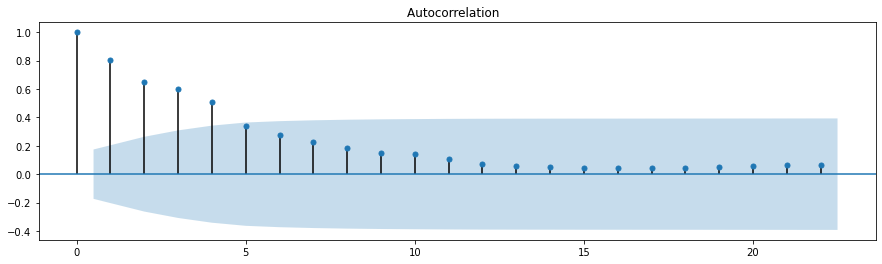

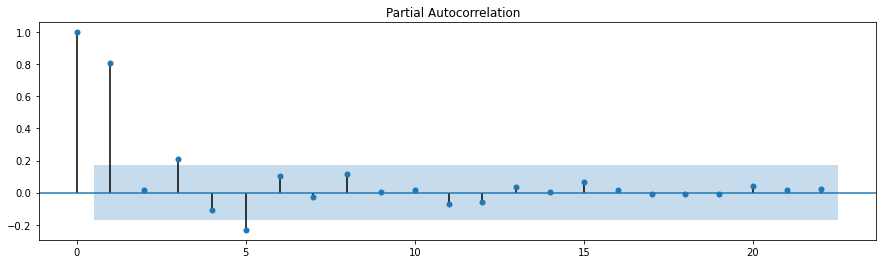

In [20]:
acf_pacf_plot(tesla_cleaned_data)

# 4. Feature Engineering

### 4.1 Log Transformation

In [21]:
tesla_cleaned_data_log = np.log(tesla_cleaned_data)

In [22]:
tesla_cleaned_data_log.tail()

,Close
Date,
2020-08-01,6.211242
2020-09-01,6.061480
2020-10-01,5.961108
2020-11-01,6.341417
2020-12-01,6.543912


In [23]:
tesla_cleaned_data.tail()

,Close
Date,
2020-08-01,498.320007
2020-09-01,429.010010
2020-10-01,388.040009
2020-11-01,567.599976
2020-12-01,695.000000


### 4.2 Differencing

In [24]:
def first_order_differencing(df):
    first_order_df = df.diff()
    return first_order_df

In [25]:
def second_order_differencing(df):
    second_order_df = df.diff(2)
    return second_order_df

#### 4.2.1 Differencing for Original Data

In [26]:
tesla_cleaned_data_first_order = first_order_differencing(tesla_cleaned_data)
tesla_cleaned_data_second_order = second_order_differencing(tesla_cleaned_data)

In [27]:
tesla_cleaned_data_first_order.head()

,Close
Date,
2010-06-01,NaN
2010-07-01,-0.778
2010-08-01,-0.092
2010-09-01,0.186
2010-10-01,0.286


In [28]:
tesla_cleaned_data_second_order.head()

,Close
Date,
2010-06-01,NaN
2010-07-01,NaN
2010-08-01,-0.870
2010-09-01,0.094
2010-10-01,0.472


#### 4.2.2 Differencing for Log Transformed Data

In [29]:
tesla_cleaned_data_log_first_order = first_order_differencing(tesla_cleaned_data_log)
tesla_cleaned_data_log_second_order = second_order_differencing(tesla_cleaned_data_log)

In [30]:
tesla_cleaned_data_log_first_order.head()

,Close
Date,
2010-06-01,NaN
2010-07-01,-0.178218
2010-08-01,-0.023339
2010-09-01,0.046637
2010-10-01,0.067718


In [31]:
tesla_cleaned_data_log_second_order.head()

,Close
Date,
2010-06-01,NaN
2010-07-01,NaN
2010-08-01,-0.201557
2010-09-01,0.023297
2010-10-01,0.114355


### 4.3 Stationarity Comparison

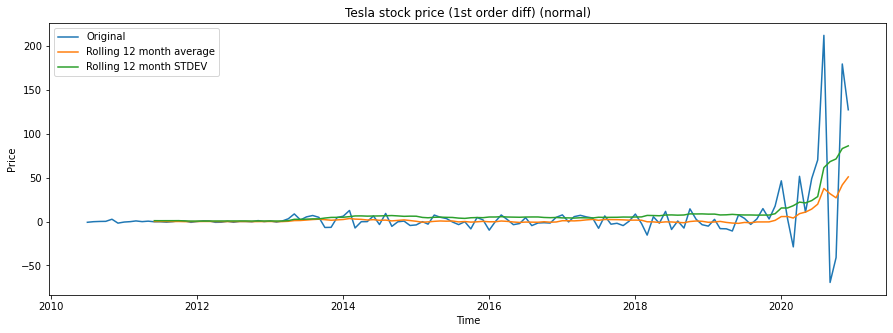

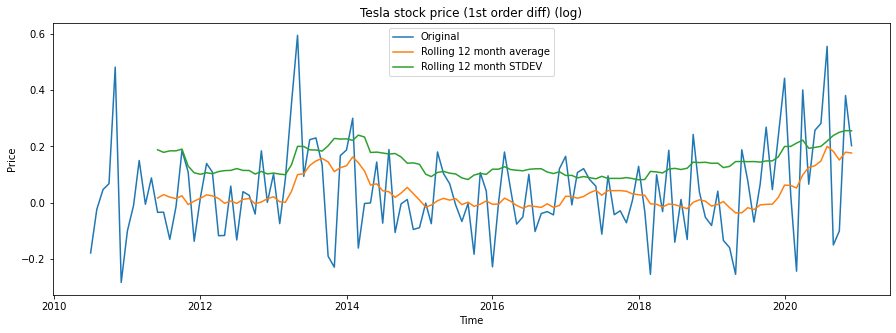

In [32]:
stationarity_plot(tesla_cleaned_data_first_order, "(1st order diff)", "(normal)")
# stationarity_plot(tesla_cleaned_data_second_order, "(2nd order diff)", "(normal)")
stationarity_plot(tesla_cleaned_data_log_first_order, "(1st order diff)", "(log)")
# stationarity_plot(tesla_cleaned_data_log_second_order, "(2nd order diff)", "(log)")

Log transformation with 1st order difference exhibits the most stationarity attributes out of all transformation.

### 4.4 Autocorrelation and Partial Autocorrelation

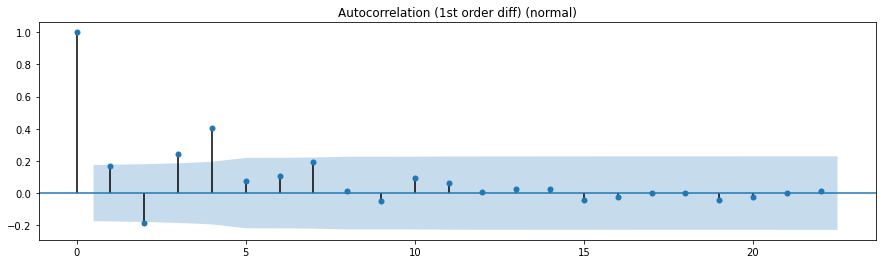

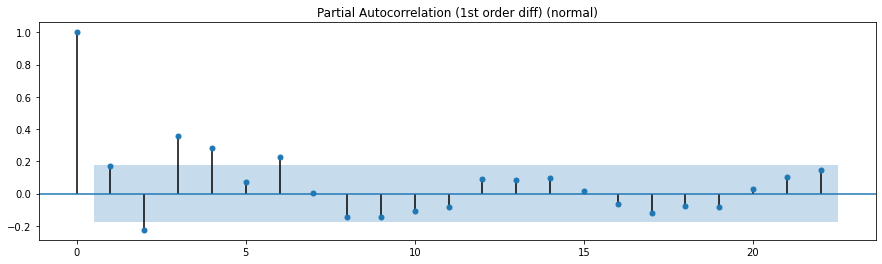

In [33]:
acf_pacf_plot(tesla_cleaned_data_first_order, "(1st order diff)", "(normal)")

In [34]:
# acf_pacf_plot(tesla_cleaned_data_second_order, "(2nd order diff)", "(normal)")

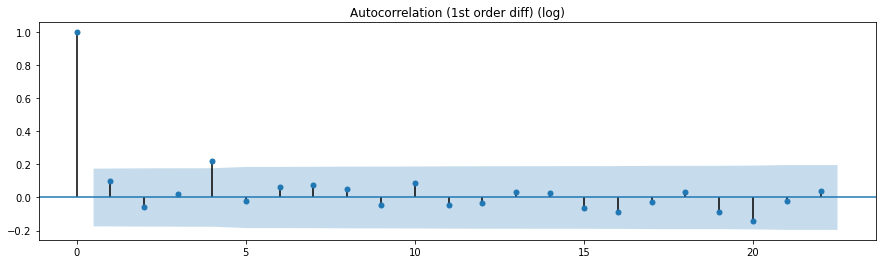

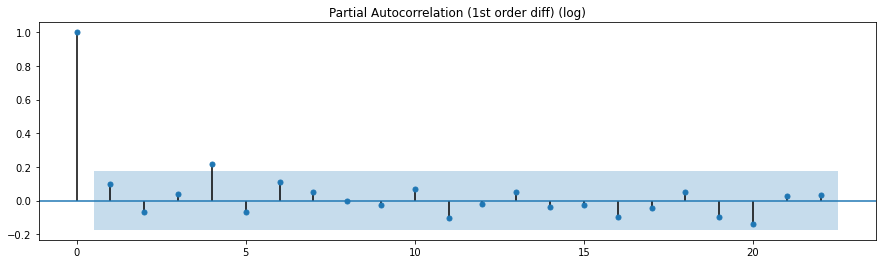

In [35]:
acf_pacf_plot(tesla_cleaned_data_log_first_order, "(1st order diff)", "(log)")

In [36]:
# acf_pacf_plot(tesla_cleaned_data_log_second_order, "(2nd order diff)", "(log)")

Log transformation with 1st order difference exhibits autocorrelation and partial autocorrelation that aligns with theory.

# 5. Forecasting

### 5.1 Split into training and validation set

In [37]:
def split_training_validation(df, training_pct=0.8):
    y = df['Close'].dropna()
    training_size = int(len(y)*training_pct)
    validation_size = len(y) - training_size
    train = y.iloc[0:training_size]
    validation = y.iloc[training_size:]
    return y, train, validation

In [38]:
def training_validation_plot(train, validation, transformation=""):
    fig, ax= plt.subplots(figsize=(15,5))
    train.plot(label='Training')
    validation.plot(label='Validation')
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.set_title('Tesla stock price {}'.format(transformation))
    plt.legend(loc='best')
    plt.show()

#### 5.1.1 Split for Original Data

In [39]:
y, train, validation = split_training_validation(tesla_cleaned_data, training_pct=0.8)

In [40]:
train.tail()

Date
2018-06-01    68.589996
2018-07-01    59.627998
2018-08-01    60.332001
2018-09-01    52.953999
2018-10-01    67.463997
Name: Close, dtype: float64

In [41]:
validation.tail()

Date
2020-08-01    498.320007
2020-09-01    429.010010
2020-10-01    388.040009
2020-11-01    567.599976
2020-12-01    695.000000
Name: Close, dtype: float64

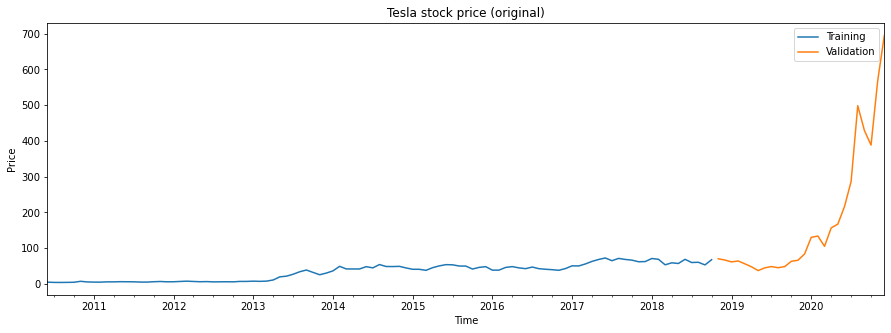

In [42]:
training_validation_plot(train, validation, "(original)")

In [43]:
y_log, train_log, validation_log = split_training_validation(tesla_cleaned_data_log, training_pct=0.8)

In [44]:
train_log.tail()

Date
2018-06-01    4.228147
2018-07-01    4.088125
2018-08-01    4.099863
2018-09-01    3.969424
2018-10-01    4.211594
Name: Close, dtype: float64

In [45]:
validation_log.tail()

Date
2020-08-01    6.211242
2020-09-01    6.061480
2020-10-01    5.961108
2020-11-01    6.341417
2020-12-01    6.543912
Name: Close, dtype: float64

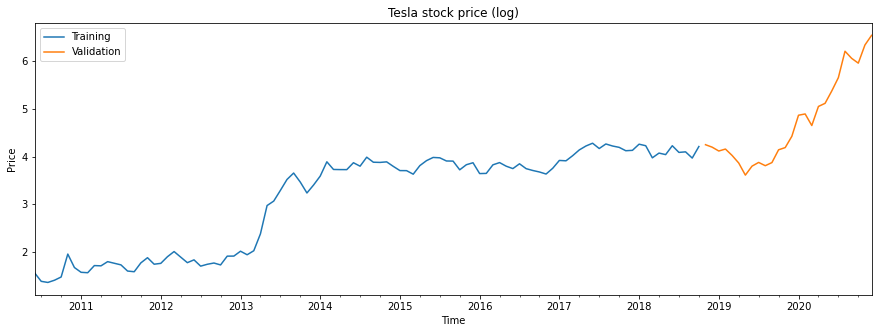

In [46]:
training_validation_plot(train_log, validation_log, "(log)")

### 5.2 Arima

#### 5.2.1 Forecast Original Observation

In [47]:
def arima_cross_validation(y, train, validation, configs):
    start = y.index.get_loc(validation.index[0])
    
    arima_preds = {}
    for config in configs:
        if config not in arima_preds:
            arima_preds[config] = []
    
    for config in configs:
        for i in range(start, len(y)):
            model = ARIMA(y_log.iloc[:i], order=config)
            fitted_model = model.fit(disp=-1)
            output = fitted_model.forecast(steps=1)
            y_hat = output[0][0]
            arima_preds[config].append(y_hat)
        
    return arima_preds

In [48]:
def convert_prediction_to_time_series(dic, series):
    dic_series = {}
    for key in dic:
        if key not in dic_series:
            dic_series[key] = pd.Series(dic[key], index=series.index)
    return dic_series

In [49]:
def time_series_exponential_transformation(dic):
    dic_exp = {}
    for key in dic:
        if key not in dic_exp:
            dic_exp[key] = np.exp(dic[key])
    
    return dic_exp

In [50]:
configs = [(3,1,2), (3,1,3)]
arima_preds = arima_cross_validation(y_log, train_log, validation_log, configs)

In [51]:
arima_preds

{(3, 1, 2): [4.231907811891459,
  4.308918817119935,
  4.191416360045601,
  4.169700034899781,
  4.219307799933003,
  4.028697953251125,
  3.860886219707565,
  3.5966082631978944,
  3.8132794513498993,
  3.9377589033756446,
  3.786661020761922,
  3.9290313557674987,
  4.181326760115889,
  4.231302295120764,
  4.4740852222084975,
  4.97058727033863,
  4.93030741619327,
  4.620133785376144,
  5.207464261727565,
  5.10043733519814,
  5.422293415737936,
  5.706077411049973,
  6.314502867695625,
  6.125414338129178,
  5.90458457610547,
  6.401370066957333],
 (3, 1, 3): [4.206317686462514,
  4.289798332045893,
  4.220122985342418,
  4.163329871710328,
  4.183233600515597,
  4.104262337372764,
  3.838892896288638,
  3.588015728184381,
  3.8041342765318418,
  3.9208843820638086,
  3.810214908999274,
  3.9081242754970615,
  4.168975644698346,
  4.22404620475296,
  4.462722920056457,
  4.924334407510006,
  4.921908740059612,
  4.670788861917369,
  5.145281443443824,
  5.108225329625361,
  5.4200

In [52]:
arima_series = convert_prediction_to_time_series(arima_preds, validation)
arima_back_transformed = time_series_exponential_transformation(arima_series)

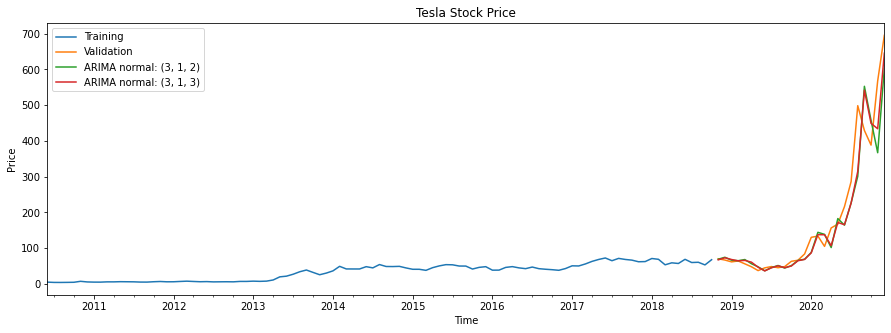

In [53]:
fig, ax= plt.subplots(figsize=(15,5))
train.plot(label='Training')
validation.plot(label='Validation')
for key in arima_back_transformed:
    arima_back_transformed[key].plot(label="ARIMA normal: {}".format(key))
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_title('Tesla Stock Price')
plt.legend(loc='best')
plt.show()

#### 5.2.2 Model Validation

In [54]:
def model_performance_metrics(fitted, actual, train, name):
    table = pd.DataFrame()
    
    #rmse and se
    y = np.array((np.ravel(actual)-np.ravel(fitted))**2)
    y_sum = np.sum(y)
    n = len(y)

    resample = np.sqrt((y_sum-y)/(n-1))

    rmse = np.sqrt(y_sum/n)
    se = np.sqrt((n-1)*np.var(resample))
    
    #mape
    y_true = np.array(actual)
    y_pred = np.array(fitted)
    percentage = np.abs((y_true - y_pred) / y_true) * 100
    mape = np.mean(percentage)
    
    #MASE
    d = np.abs(np.diff(train)).sum()/(n-1)
    
    errors = np.abs(actual - fitted)
    mase = errors.mean()/d
    
    table['MASE'] = [mase]
    table['MAPE'] = [mape]
    table['RMSE'] = [rmse]
    table['SE'] = [se]
    table.index = [name]
    return table.round(4)

In [55]:
model_1_perf = model_performance_metrics(arima_back_transformed[(3,1,2)], validation, train, "Model 1")
model_2_perf = model_performance_metrics(arima_back_transformed[(3,1,3)], validation, train, "Model 2")

In [56]:
model_results = pd.concat([model_1_perf, model_2_perf])
model_results

,MASE,MAPE,RMSE,SE
Model 1,2.9537,18.1241,68.3487,16.7366
Model 2,2.4953,16.7755,56.5547,14.1684


#### 5.2.3 Model Diagnostic

In [57]:
def forecast_model_diagnostic(resid):
    #residual plot
    fig, ax= plt.subplots(figsize=(8,5))
    resid.plot()
    ax.set_xlabel('')
    ax.set_xticks([], minor=True) 
    ax.set_title('Residual plot')
    sns.despine()
    plt.show()
    
    #autocorrelation plot
    fig, ax = plt.subplots(figsize=(8,5))
    sm.graphics.tsa.plot_acf(resid, lags=10, ax=ax)
    sns.despine()
    plt.show()
    
    #residual distribution plot
    fig, ax= plt.subplots(figsize=(8,5))
    sns.distplot(resid)
    ax.set_title('Residual distribution plot')
    ax.set_ylabel('Density')
    ax.set_xlabel('Residual')
    plt.show()

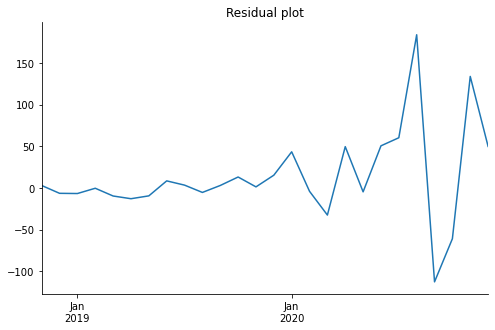

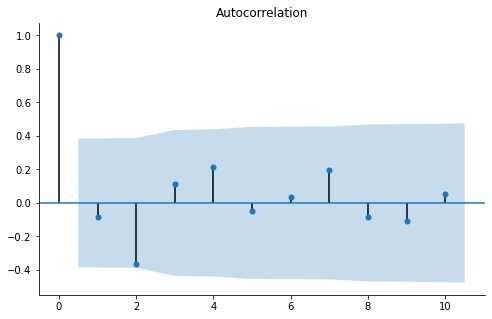

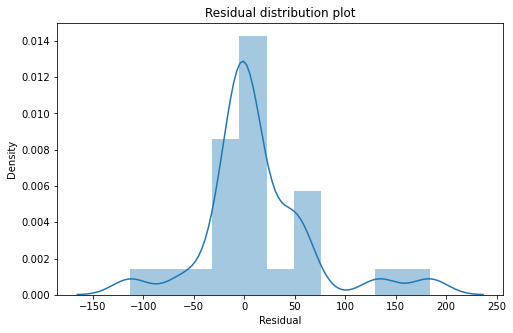

In [58]:
resid_arima = validation - arima_back_transformed[(3,1,3)]
forecast_model_diagnostic(resid_arima)

#### 5.2.5 Forecast Next 24 Months

In [59]:
model = ARIMA(y_log, order=(3,1,3))
fitted_model = model.fit(disp=-1)
output = fitted_model.forecast(steps=24)
y_hat_final = output[0]

In [60]:
forecast__arima_index = pd.date_range(start='1/1/2021', periods=24, freq='MS')
forecast_arima_24 = pd.Series(y_hat_final, index=forecast__arima_index)
forecast_arima_24_back_transformed = np.exp(forecast_arima_24)
forecast_arima_24_back_transformed

2021-01-01     748.888193
2021-02-01     823.155154
2021-03-01     864.696591
2021-04-01     921.804715
2021-05-01     998.184805
2021-06-01    1042.967925
2021-07-01    1103.803198
2021-08-01    1182.583242
2021-09-01    1231.774514
2021-10-01    1297.209093
2021-11-01    1379.204848
2021-12-01    1434.097732
2022-01-01    1505.214272
2022-02-01    1591.560687
2022-03-01    1653.501896
2022-04-01    1731.513414
2022-05-01    1823.543393
2022-06-01    1893.915284
2022-07-01    1980.134685
2022-08-01    2079.320217
2022-09-01    2159.553127
2022-10-01    2255.392046
2022-11-01    2363.324620
2022-12-01    2454.923376
Freq: MS, dtype: float64

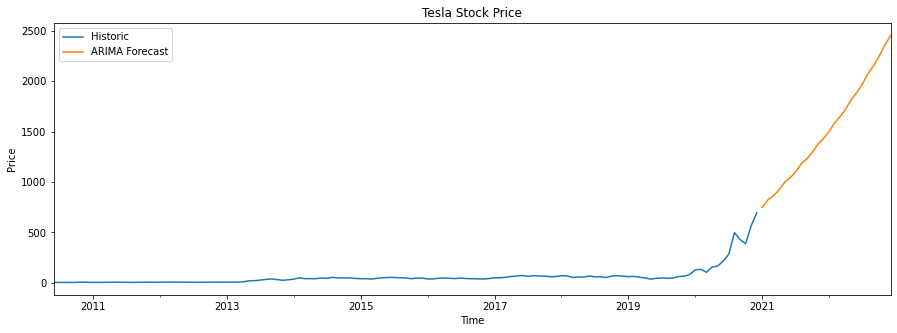

In [61]:
fig, ax= plt.subplots(figsize=(15,5))
y.plot(label='Historic')
forecast_arima_24_back_transformed.plot(label="ARIMA Forecast")
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_title('Tesla Stock Price')
plt.legend(loc='best')
plt.show()

### 5.3 Holt Winters Exponential Smoothing

#### 5.3.1 Forecast Observations

In [62]:
def forecast_observation(train, validation, fitted, name):
    fig, ax= plt.subplots(figsize=(15,5))
    train.plot(label='Training')
    validation.plot(label='Validation')
    fitted.plot(label=name)
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.set_title('Tesla Stock Price')
    plt.legend(loc='best')
    plt.show()

In [63]:
def holt_winters_cross_validation(y, validation, configs):
    start = y.index.get_loc(validation.index[0])
    
    hw_preds = {}
    for config in configs:
        pred_hw = []
        for i in range(start, len(y)):
            model = forecast.holtwinters(y.iloc[:i], additive=config[0], damped=config[1], m=12)
            model.fit()
            pred_hw.append(model.forecast(1)[0])
            
        hw_preds[tuple(config)] = pred_hw
        
    return hw_preds

In [64]:
configs = [
    [True, True],
    [True, False],
    [False, True],
    [False, False],
]
hw_preds = holt_winters_cross_validation(y, validation, configs)

In [65]:
hw_series = convert_prediction_to_time_series(hw_preds, validation)
hw_series

{(True,
  True): Date
 2018-11-01     56.944795
 2018-12-01     62.512240
 2019-01-01     65.647740
 2019-02-01     66.475997
 2019-03-01     64.859883
 2019-04-01     65.776926
 2019-05-01     62.322730
 2019-06-01     54.864915
 2019-07-01     45.390074
 2019-08-01     44.350549
 2019-09-01     45.563481
 2019-10-01     44.433072
 2019-11-01     47.902889
 2019-12-01     55.181480
 2020-01-01     65.979634
 2020-02-01     76.229938
 2020-03-01    106.154053
 2020-04-01    134.340007
 2020-05-01    125.920873
 2020-06-01    158.349623
 2020-07-01    176.297572
 2020-08-01    230.112680
 2020-09-01    357.987492
 2020-10-01    506.408052
 2020-11-01    446.061388
 2020-12-01    506.289438
 dtype: float64,
 (True,
  False): Date
 2018-11-01     55.997854
 2018-12-01     68.820561
 2019-01-01     69.689213
 2019-02-01     66.668419
 2019-03-01     62.467436
 2019-04-01     65.014255
 2019-05-01     58.057327
 2019-06-01     47.402070
 2019-07-01     35.387911
 2019-08-01     42.668142
 2

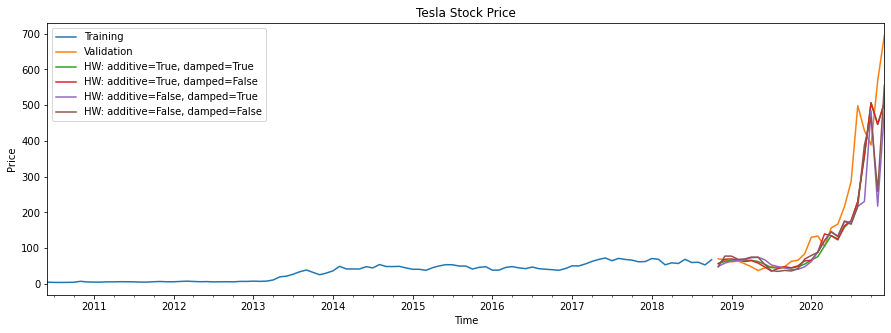

In [66]:
fig, ax= plt.subplots(figsize=(15,5))
train.plot(label='Training')
validation.plot(label='Validation')
for key in hw_series:
    hw_series[key].plot(label="HW: additive={}, damped={}".format(key[0], key[1]))
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_title('Tesla Stock Price')
plt.legend(loc='best')
plt.show()

#### 5.3.2 Model Validation

In [67]:
df_ls = []
for i in range(len(configs)):
    model_perf = model_performance_metrics(hw_series[tuple(configs[i])], validation, train, 
                                           "Model {} ({})".format(i+2, configs[i]))
    df_ls.append(model_perf)

In [68]:
model_results = pd.concat(df_ls)
model_results

,MASE,MAPE,RMSE,SE
"Model 2 ([True, True])",3.6092,24.2775,80.6702,20.6391
"Model 3 ([True, False])",3.6208,24.1639,80.4182,20.7317
"Model 4 ([False, True])",4.7800,31.6126,111.8426,27.4967
"Model 5 ([False, False])",3.9719,30.3133,93.9086,27.1722


In [69]:
configs[0]

[True, True]

#### 5.3.3 Model Diagnostic

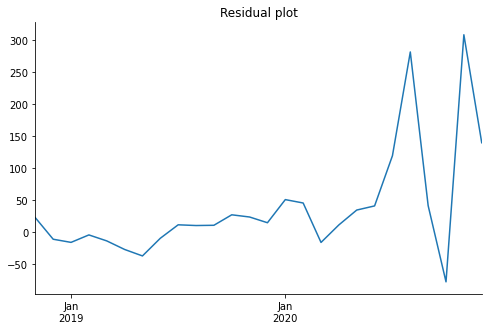

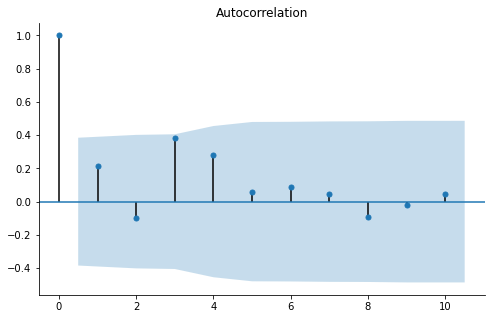

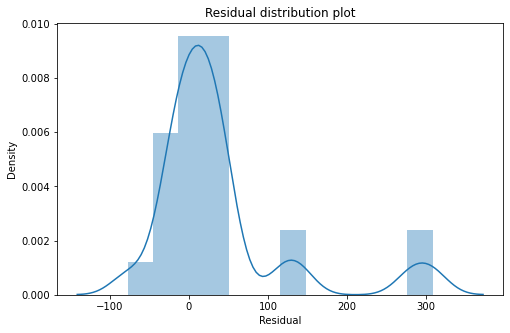

In [70]:
resid_hw = validation - hw_series[tuple(configs[3])]
forecast_model_diagnostic(resid_hw)

#### 5.3.4 Forecast Next 24 Months

In [71]:
def forecast_observation_variant(y, fitted, name):
    fig, ax= plt.subplots(figsize=(15,5))
    y.plot(label='Observed')
    fitted.plot(label=name)
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.set_title('Tesla Stock Price')
    plt.legend(loc='best')
    plt.show()

In [72]:
h=24
mhw=forecast.holtwinters(y, additive=False, damped=False, m=12)
mhw.fit()
print('alpha: {:.4f}'.format(mhw.alpha))
print('beta: {:.4f}'.format(mhw.beta))
print('delta: {:.4f}'.format(mhw.delta))
mhw.summary()
forecast_mhw_index = pd.period_range(start="2021-01-01", periods=h, freq='M')
forecast_hw = pd.Series(mhw.forecast(h), index=forecast_mhw_index)

alpha: 0.8104
beta: 0.1502
delta: 0.5764
 Multiplicative Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.810 (0.168)
 beta  (trend)    0.150 (0.109)
 delta (seasonal) 0.576 (0.174)
 
 In-sample fit:
 MSE               896.559
 RMSE              29.943
 Log-likelihood   -611.914
 AIC               1231.828
 BIC               1243.205


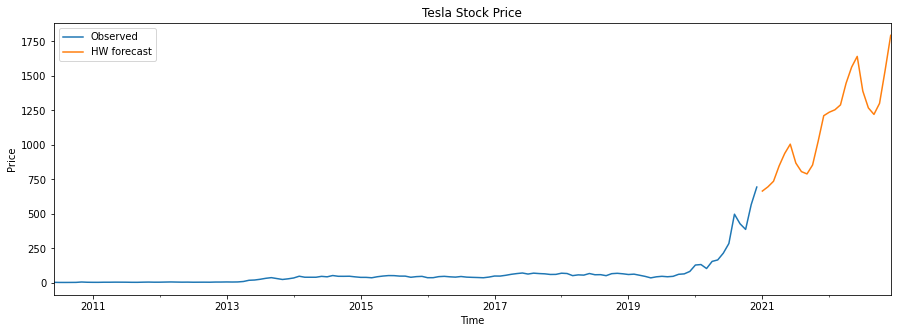

In [73]:
forecast_observation_variant(y, forecast_hw, 'HW forecast')

# 6. Final Forecast

In [74]:
def create_upper_lower_bound(mean, se, alpha):
    result = []
    p_value = (alpha+1) / 2
    z_score = stats.norm.ppf(p_value)
    
    for i in range(len(mean)):
        current_lower_upper = []
        error = se[i] * z_score
        current_lower_upper.append(mean[i]-error)
        current_lower_upper.append(mean[i]+error)
        
        result.append(current_lower_upper)
        
    return result

In [75]:
def create_conf_intv(arr, start_period, num_periods):
    lower_arr = [x[0] for x in arr]
    upper_arr = [x[1] for x in arr]

    forecast__index = pd.date_range(start=start_period, periods=num_periods, freq='MS')
    
    lower_intv = pd.Series(lower_arr, index=forecast__index)
    upper_intv = pd.Series(upper_arr, index=forecast__index)
    lower_intv_exp = np.exp(lower_intv)
    upper_intv_exp = np.exp(upper_intv)
    
    return pd.concat([lower_intv_exp, upper_intv_exp], axis=1)

In [76]:
def fanchart(y, forecast, intv1, alpha):
    fig, ax= plt.subplots(figsize=(15,5))
    first = forecast.iloc[:1]
    extended = y.append(first)
    ax.plot(extended, color='#D62728', label='Historic')
    ax.plot(forecast, color='black', alpha=0.6, label='ARIMA forecast (3,1,3)')
    ax.fill_between(forecast.index, intv1.iloc[:,0], 
                    intv1.iloc[:,1], facecolor='#FAB8A4', lw=0, 
                    label='{:.0f}% confidence interval'.format(alpha))
    ax.fill_betweenx(ax.get_ylim(), forecast.index[0], forecast.index[-1], facecolor='grey', alpha=0.15, 
                     label='Forecast Region')
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.set_title('Tesla Stock Price')
    plt.legend(loc='upper left')
    plt.show()

In [77]:
alpha = 0.5
conf_intv = create_upper_lower_bound(output[0], output[1], alpha)
intv1 = create_conf_intv(conf_intv, '1/1/2021', 24)

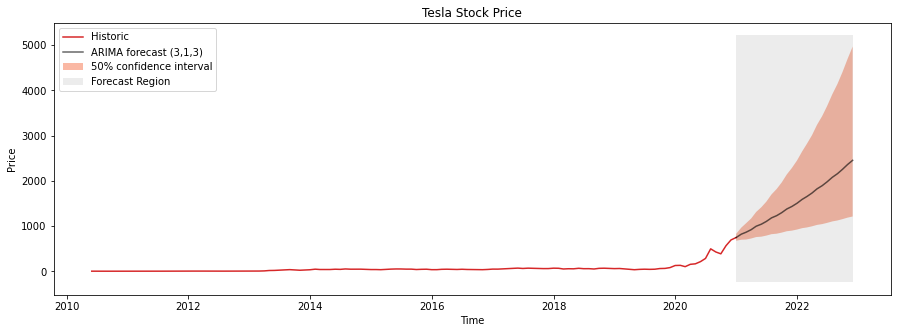

In [78]:
fanchart(y, forecast_arima_24_back_transformed, intv1, alpha*100)